In [1]:
import io
import pandas as pd

def parse_data(fpath):
    with open(fpath, 'r') as f:
        data = {}
        date = None

        for line in f.readlines():
            if line.startswith('#'):
                date = line.replace('#', '').strip()
                data[date] = []
            else:
                data[date].append(line)
                
    data = {k: ''.join(v) for k, v in data.items()}
    data = {k: pd.read_csv(io.BytesIO(str.encode(v)), sep='\t')
            for k, v in data.items()}
    for k, df in data.items():
        df['date'] = k
        
    df = pd.concat(data.values()).reset_index(drop=True)
    return df

df = pd.concat([parse_data('daily-leaders-202110.txt'), 
                parse_data('daily-leaders-202111.txt')]).reset_index(drop=True)

In [2]:
df.shape

(1170, 17)

In [3]:
df.head()

,RK,PLAYER,TEAM,OPP,SCORE,MIN,FGM-A,3PM-A,FTM-A,REB,AST,STL,BLK,TO,PTS,ESPN,date
0,1.0,G. Antetokounmpo,Mil,BKN,104-127 W,31,12-25,1-4,7-9,14,7,1,2,4,32,59.1,20211019
1,2.0,L. James,LAL,GS,121-114 L,37,13-23,5-11,3-6,11,5,1,1,4,34,57.5,20211019
2,3.0,K. Durant,BKN,@Mil,104-127 L,30,13-25,3-7,3-6,11,4,0,2,1,32,54.0,20211019
3,4.0,A. Davis,LAL,GS,121-114 L,39,15-26,1-5,2-7,11,2,1,2,0,33,53.8,20211019
4,5.0,J. Harden,BKN,@Mil,104-127 L,31,6-16,4-8,4-4,8,8,1,2,4,20,41.2,20211019


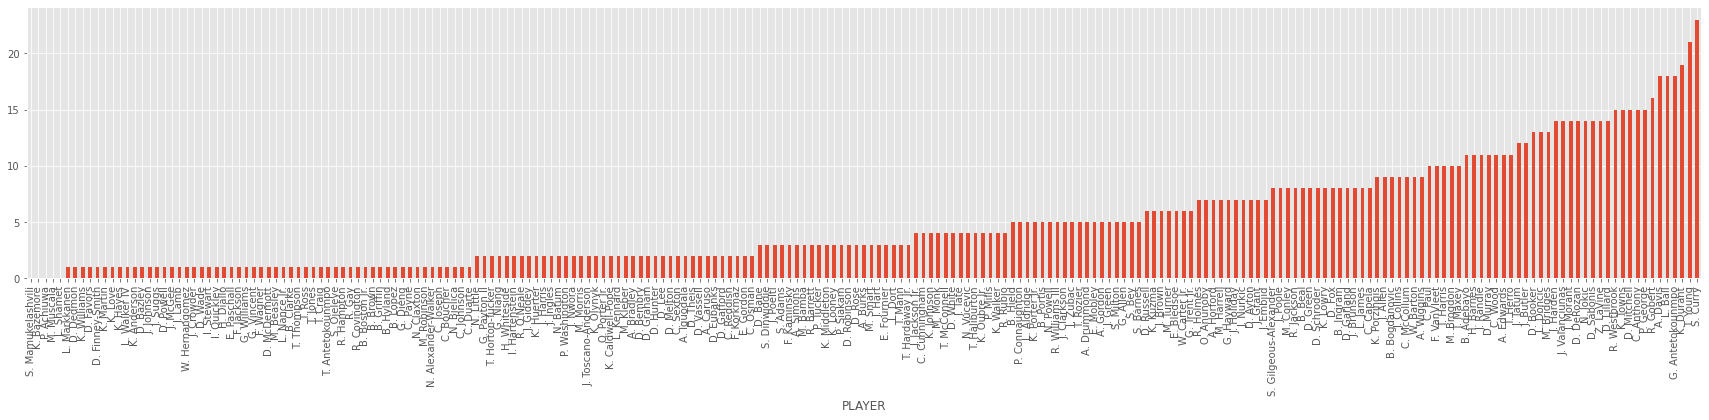

In [40]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

s = df.groupby(['PLAYER'])\
        .agg('count')[['RK']]\
        .rename(columns={'RK': 'n'})\
        .sort_values(['n'])['n']

_ = s.plot(kind='bar', figsize=(30, 5))

In [73]:
valid_players = set(s[s >= 15].index)
print(len(valid_players))
valid_players

12


{'A. Davis',
 'C. Anthony',
 'D. Mitchell',
 'G. Antetokounmpo',
 'K. Durant',
 'K. Towns',
 'L. Ball',
 'P. George',
 'R. Gobert',
 'R. Westbrook',
 'S. Curry',
 'T. Young'}

In [74]:
players = sorted(list(df['PLAYER'].unique()))
players = [p for p in players if p in valid_players]
p2i = {p: i for i, p in enumerate(players)}
n_players = len(players)

n_players

12

In [75]:
dates = sorted(list(df['date'].unique()))

len(dates)

39

In [76]:
from itertools import combinations, chain
import numpy as np

def get_indices(date, field, ascending):
    p = df[df.date == date].sort_values([field], ascending=ascending)[['PLAYER', field]]
    p['index'] = p['PLAYER'].apply(lambda n: p2i[n] if n in p2i else -1)
    p = [(r['index'], r[field]) for _, r in p.iterrows() if r['index'] >= 0]
    p = combinations(p, 2)
    p = filter(lambda tup: tup[0][1] != tup[1][1], p)
    p = map(lambda tup: (tup[0][0], tup[1][0]), p)

    return p

def get_mat(field, ascending):
    indices = chain(*(get_indices(d, field, ascending) for d in dates))
    mat = np.zeros([n_players, n_players])

    for r, c in indices:
        mat[r, c] += 1

    mat = pd.DataFrame(mat, columns=players, index=players)
    
    return mat

In [77]:
mat_espn = get_mat('ESPN', False)
mat_pts = get_mat('PTS', False)

print(mat_espn.shape, mat_pts.shape)

(12, 12) (12, 12)


In [78]:
def get_estimate(i, p, df):
    get_prob = lambda i, j: np.nan if i == j else p.iloc[i] + p.iloc[j]
    n = df.iloc[i].sum()
    
    d_n = df.iloc[i] + df.iloc[:, i]
    d_d = pd.Series([get_prob(i, j) for j in range(len(p))], index=p.index)
    d = (d_n / d_d).sum()
    
    return n / d

def estimate_p(p, df):
    return pd.Series([get_estimate(i, p, df) for i in range(df.shape[0])], index=p.index)


def iterate(df, p=None, n=20, sorted=True):
    if p is None:
        p = pd.Series([1 for _ in range(df.shape[0])], index=list(df.columns))
        
    estimates = [p]
    
    for _ in range(n):
        p = estimate_p(p, df)
        p = p / p.sum()
        estimates.append(p)
    
    p = p.sort_values(ascending=False) if sorted else p
    return p, pd.DataFrame(estimates)

In [79]:
p_espn, estimates_espn = iterate(mat_espn, n=100)

In [80]:
p_pts, estimates_pts = iterate(mat_pts, n=100)

In [81]:
p_espn

G. Antetokounmpo    0.169129
K. Durant           0.123947
P. George           0.112621
C. Anthony          0.097591
L. Ball             0.081269
S. Curry            0.070729
A. Davis            0.068102
T. Young            0.066863
R. Westbrook        0.064058
R. Gobert           0.054975
D. Mitchell         0.049025
K. Towns            0.041690
dtype: float64

In [82]:
p_pts

K. Durant           0.164622
P. George           0.142649
G. Antetokounmpo    0.123481
C. Anthony          0.105930
S. Curry            0.101202
T. Young            0.073488
K. Towns            0.071364
A. Davis            0.068710
D. Mitchell         0.066100
L. Ball             0.040471
R. Westbrook        0.027864
R. Gobert           0.014119
dtype: float64

In [83]:
pd.DataFrame([p_espn.sort_index(), p_pts.sort_index()]).T.rename(columns={0: 'ESPN', 1: 'PTS'}).corr()

,ESPN,PTS
ESPN,1.000000,0.713141
PTS,0.713141,1.000000


<AxesSubplot:xlabel='ESPN', ylabel='PTS'>

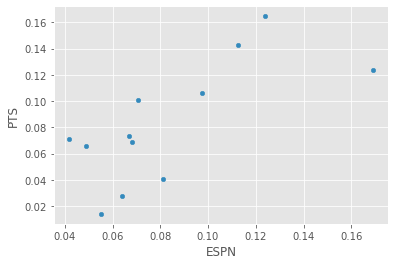

In [84]:
pd.DataFrame([p_espn.sort_index(), p_pts.sort_index()]).T.rename(columns={0: 'ESPN', 1: 'PTS'}).plot(kind='scatter', x='ESPN', y='PTS')

In [85]:
mat_espn.sum(axis=1).sort_values(ascending=False)

K. Durant           65.0
G. Antetokounmpo    62.0
S. Curry            54.0
L. Ball             48.0
C. Anthony          45.0
T. Young            45.0
A. Davis            41.0
P. George           39.0
R. Westbrook        36.0
R. Gobert           29.0
D. Mitchell         26.0
K. Towns            23.0
dtype: float64

In [86]:
mat_espn.mean(axis=1).sort_values(ascending=False)

K. Durant           5.416667
G. Antetokounmpo    5.166667
S. Curry            4.500000
L. Ball             4.000000
C. Anthony          3.750000
T. Young            3.750000
A. Davis            3.416667
P. George           3.250000
R. Westbrook        3.000000
R. Gobert           2.416667
D. Mitchell         2.166667
K. Towns            1.916667
dtype: float64